In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet

2023-01-12 15:43:28.983237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 15:43:29.423604: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 15:43:30.222259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-12 15:43:30.222321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def fill_missing_weeks_with_zeros(input_series):
    start_ts = input_series.index[0]
    finish_ts = input_series.index[-1]
    current_ts = start_ts
    out_ts = pd.Series(dtype=input_series.dtype)
    while current_ts <= finish_ts:
        if current_ts in input_series.index:
            out_ts[current_ts] = input_series[current_ts]
        else:
            out_ts[current_ts] = 0
        current_ts = current_ts + datetime.timedelta(days=7)
    return out_ts



def create_dataset(time_series, n_lags):
    time_series = time_series.to_numpy()
    X = []
    Y = []
    for t in range(len(time_series) - n_lags):
        x = time_series[t:t+n_lags]
        X.append(x)
        y = time_series[t+n_lags]
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    train_len = int(len(X) * 0.8)
    Xtrain = X[:train_len]
    Ytrain = Y[:train_len]
    Xtest = X[train_len:]
    Ytest = Y[train_len:]
    return Xtrain, Ytrain, Xtest, Ytest



def transform_to_monthly(ts_weeks):
    ts_months = pd.Series(dtype=ts_weeks.dtype)
    start_ts = ts_weeks.index[0]
    finish_ts = ts_weeks.index[-1]
    current_ts = start_ts
    while current_ts <= finish_ts:
        cur_month = datetime.datetime(current_ts.year, current_ts.month, 1)
        if ts_months.get(cur_month) == None:
            ts_months[cur_month] = 0
        ts_months[cur_month] += ts_weeks[current_ts]
        current_ts = current_ts + datetime.timedelta(days=7)
    return ts_months

def trim_timeseries(ts, quantile):
    '''
    ts --- pandas Series
    quantile --- part in left and right side to be trimmed

    returns new pandas Series with the same index, but values above (below)
    quantiles will be replaced with corresponding quantile values
    '''
    arr = ts.to_numpy(copy=True)
    arr.sort()
    part = int(len(arr) * quantile)
    min_val = arr[part]
    max_val = arr[-part]
    res_ts = ts.copy()
    for i in range(len(res_ts)):
        if res_ts[i] < min_val:
            res_ts[i] = min_val
        elif res_ts[i] > max_val:
            res_ts[i] = max_val
    return res_ts


def plot_different_years(ts):
    plt.figure(figsize=(15, 5))
    for year in [2018, 2019, 2020, 2021]:
        ts_year = ts[(ts.index >= datetime.datetime(year, 1, 1)) &
                     (ts.index <= datetime.datetime(year, 12, 31, 23, 59, 59))]
        ts_unified = pd.Series(dtype=ts_year.dtype)
        for k, v in ts_year.items():
            ts_unified[datetime.date(1970, k.month, k.day)] = v
        plt.plot(ts_unified, '-', label=str(year))

    plt.legend()
    plt.show()



def plot_different_years_months(ts_months):
    nmonths = 12
    plt.figure(figsize=(15, 5))
    for year in [2018, 2019, 2020, 2021]:
        ts_cur = pd.Series(dtype=ts_months.dtype, index=list(range(1, nmonths + 1)))
        for month in range(1, nmonths + 1):
            ts_cur[month] = ts_months[datetime.datetime(year, month, 1)]
        plt.plot(ts_cur, '-', label=str(year))
    plt.legend()
    plt.show()

## Load Time Series
N_TASKS

In [16]:
df = pd.read_csv('group_samples/data_weekly_from2017.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df['INPUT_FORMAT_DESC'].fillna('-',inplace=True)

Choosing (MUON, data16_13TeV, DAOD)

In [12]:
ds_group_ts = df[(df['INPUT_FORMAT_DESC'].str.contains('MUON')) &
                 (df['INPUT_FORMAT_SHORT'] == 'DAOD') &
                 (df['INPUT_PROJECT'] == 'data16_13TeV')][['DATETIME', 'N_TASKS']]
ds_group_ts = ds_group_ts.groupby('DATETIME')['N_TASKS'].sum()
ds_group_ts = fill_missing_weeks_with_zeros(ds_group_ts)

Choosing (HIGG, mc16_13TeV, DAOD)

In [17]:
ds_group_ts = df[(df['INPUT_FORMAT_DESC'].str.contains('HIGG')) &
                 (df['INPUT_FORMAT_SHORT'] == 'DAOD') &
                 (df['INPUT_PROJECT'] == 'mc16_13TeV')][['DATETIME', 'N_TASKS']]
ds_group_ts = ds_group_ts.groupby('DATETIME')['N_TASKS'].sum()
ds_group_ts = fill_missing_weeks_with_zeros(ds_group_ts)

Choosing (TOPQ, mc16_13TeV, DAOD)

In [14]:
ds_group_ts = df[(df['INPUT_FORMAT_DESC'].str.contains('TOPQ')) &
                 (df['INPUT_FORMAT_SHORT'] == 'DAOD') &
                 (df['INPUT_PROJECT'] == 'mc16_13TeV')][['DATETIME', 'N_TASKS']]
ds_group_ts = ds_group_ts.groupby('DATETIME')['N_TASKS'].sum()
ds_group_ts = fill_missing_weeks_with_zeros(ds_group_ts)

## Watching data

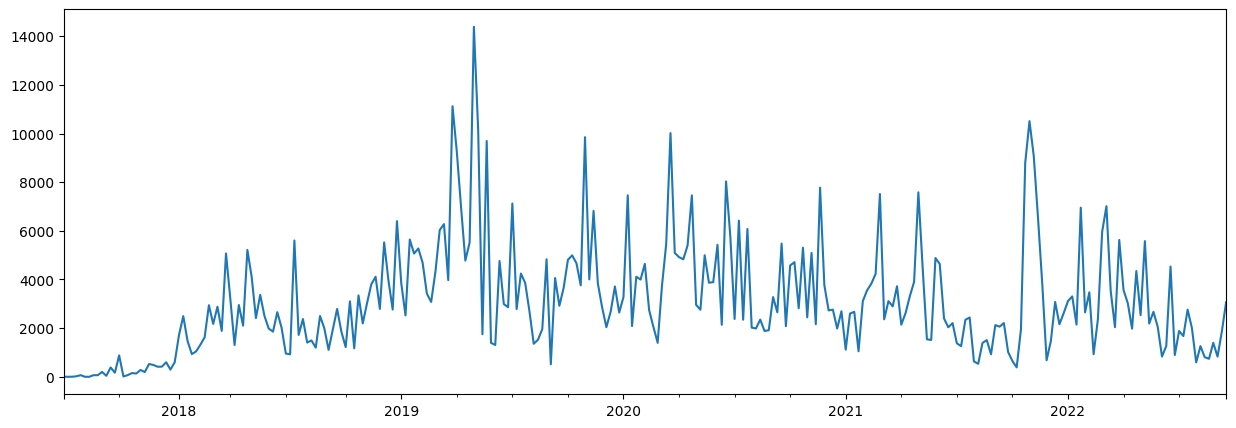

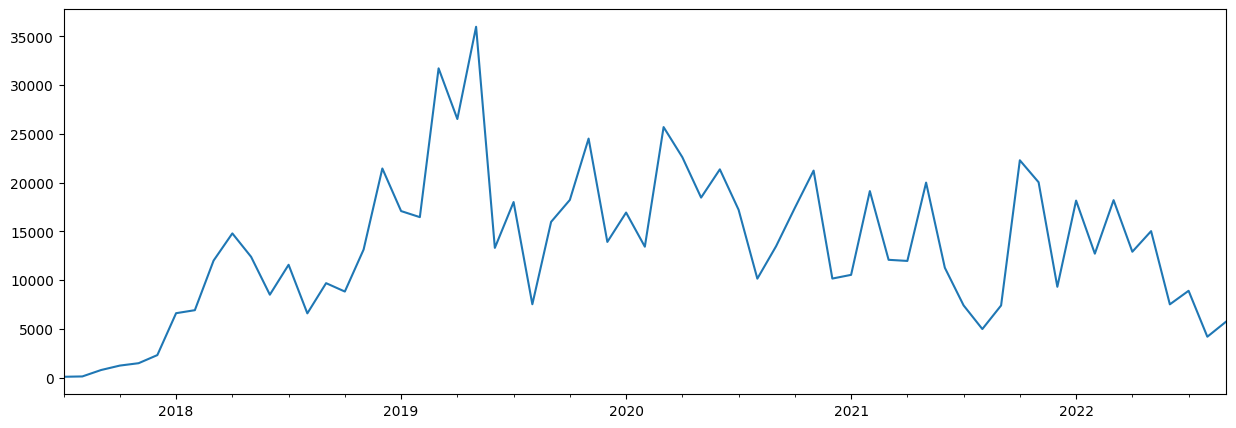

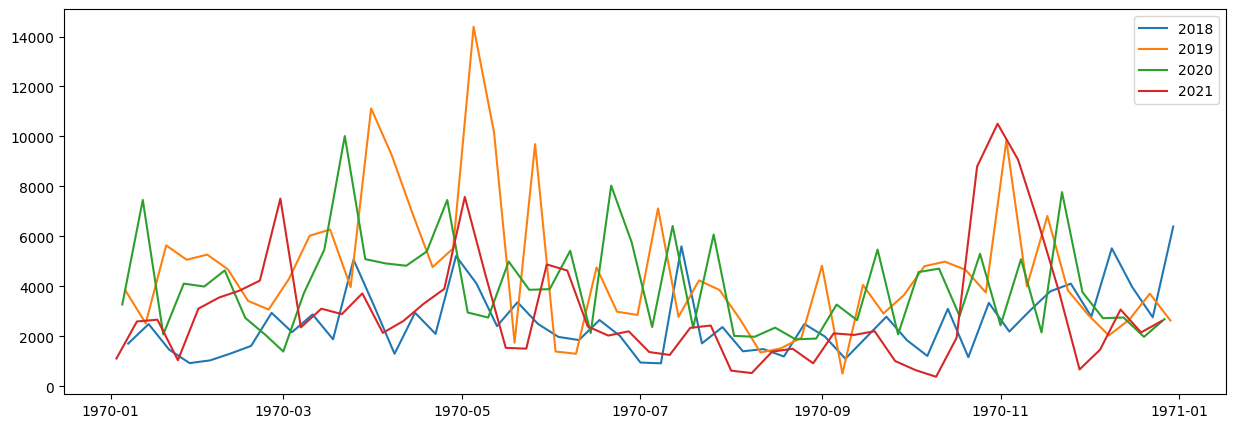

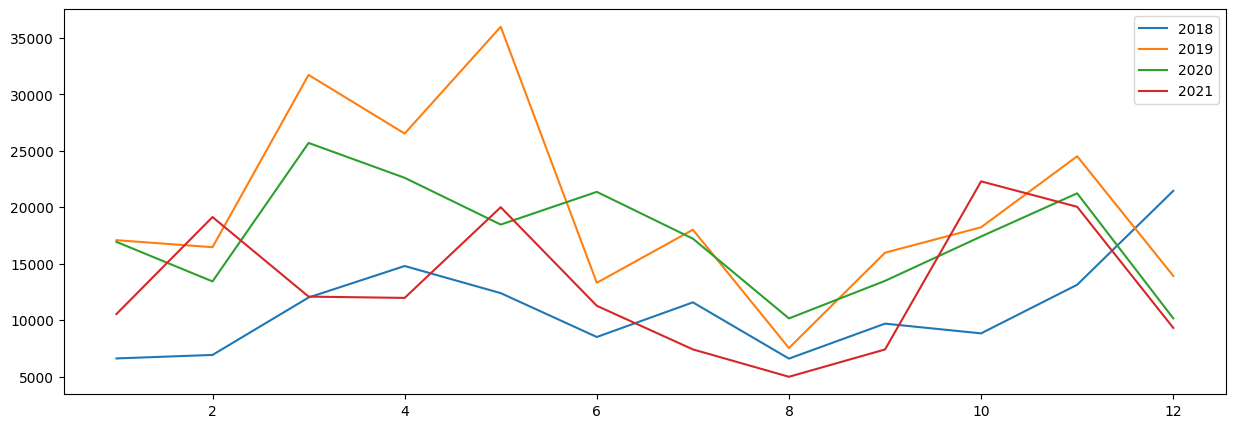

In [18]:
ds_group_ts.plot(figsize=(15, 5))
ds_group_ts_months = transform_to_monthly(ds_group_ts)
plt.figure()
ds_group_ts_months.plot(figsize=(15, 5))
plot_different_years(ds_group_ts)
plot_different_years_months(ds_group_ts_months)

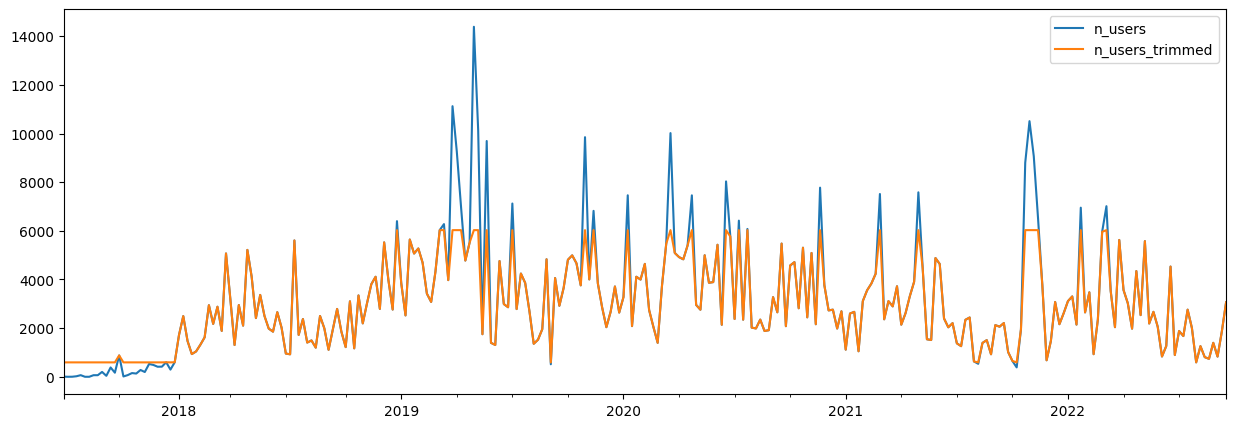

In [19]:
ts_trimmed = trim_timeseries(ds_group_ts, 0.1)
ds_group_ts.plot(figsize=(15, 5), label='n_users')
ts_trimmed.plot(figsize=(15, 5), label='n_users_trimmed')
plt.legend()

## Way 1
Preprocessing: log (N_USERS + 1) / 12.0
Predicting with a simple LSTM cell (1 input, 1 output, 32 recurrences)

Epoch 1/100
6/6 [==============================] - 2s 61ms/step - loss: 0.1227 - val_loss: 0.1149
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1156 - val_loss: 0.1081
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1086 - val_loss: 0.1014
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1018 - val_loss: 0.0949
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0950 - val_loss: 0.0885
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0885 - val_loss: 0.0823
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0821 - val_loss: 0.0763
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0760 - val_loss: 0.0705
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0701 - val_loss: 0.0649
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.0596
Epoch 11/100
6/6 [==========

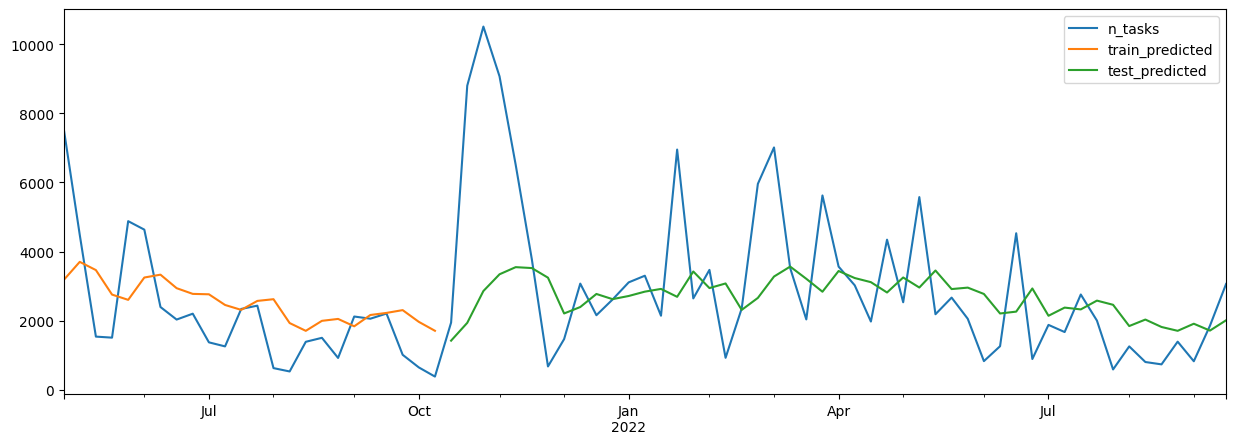

In [20]:
maxlog_ntasks = 12.0
log_ntasks_ts = np.log(ds_group_ts + 1) / maxlog_ntasks
n_lags = 32
Xtrain, Ytrain, Xtest, Ytest = create_dataset(log_ntasks_ts, n_lags)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(1, input_shape=(n_lags, 1)))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

train_idx = ds_group_ts.index[n_lags: n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()

results = pd.DataFrame({'n_tasks' : ds_group_ts})
results.loc[train_idx, 'train_predicted'] = np.exp(Ytrain_predicted * maxlog_ntasks) - 1
results.loc[test_idx, 'test_predicted'] = np.exp(Ytest_predicted * maxlog_ntasks) - 1

results[200:].plot(figsize=(15, 5))
print('MSE =', ((results['test_predicted'][test_idx] - results['n_tasks'][test_idx])**2).mean())
MAPE = mean_absolute_percentage_error(results['n_tasks'][test_idx],
                                      results['test_predicted'][test_idx])
print('MAPE =', MAPE)

## Way 2
Predicting Diff (log (N_USERS + 1))
with a simple LSTM Cell

Epoch 1/100
6/6 [==============================] - 2s 66ms/step - loss: 0.4513 - val_loss: 0.5716
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4508 - val_loss: 0.5712
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4501 - val_loss: 0.5708
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4496 - val_loss: 0.5704
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4491 - val_loss: 0.5699
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4485 - val_loss: 0.5695
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4479 - val_loss: 0.5691
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4473 - val_loss: 0.5686
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4467 - val_loss: 0.5682
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4461 - val_loss: 0.5678
Epoch 11/100
6/6 [==========

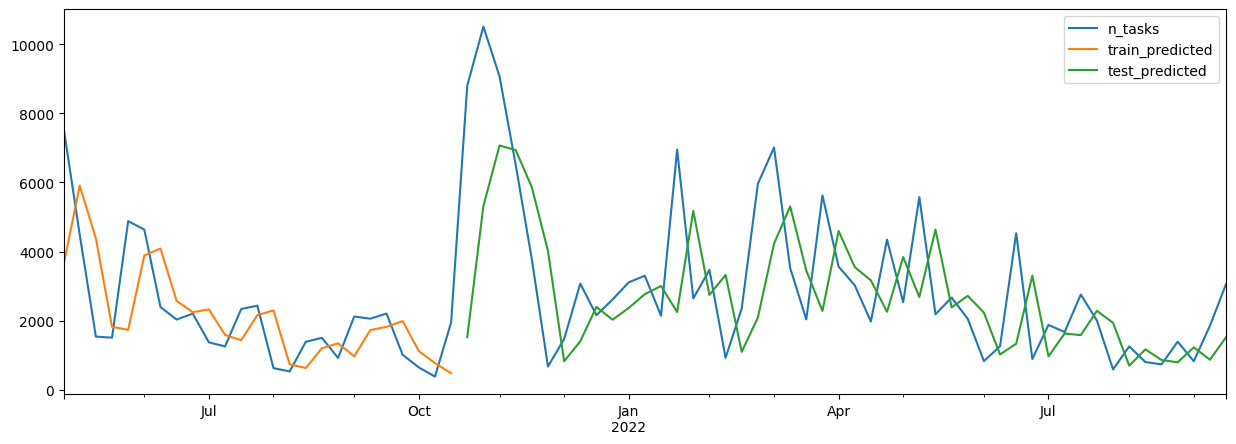

In [21]:
log_ntasks_ts = np.log(ds_group_ts + 1)
log_ntasks_diff = log_ntasks_ts.diff().dropna()
n_lags = 32
Xtrain, Ytrain, Xtest, Ytest = create_dataset(log_ntasks_diff, n_lags)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(1, input_shape=(n_lags, 1)))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

train_idx = ds_group_ts.index[1 + n_lags: 1 + n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[1 + n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()

prev = log_ntasks_ts.shift().dropna()
Ytrain_predicted = Ytrain_predicted + prev[train_idx].to_numpy()
Ytest_predicted = Ytest_predicted + prev[test_idx].to_numpy()

results = pd.DataFrame({'n_tasks' : ds_group_ts})
results.loc[train_idx, 'train_predicted'] = np.exp(Ytrain_predicted) - 1
results.loc[test_idx, 'test_predicted'] = np.exp(Ytest_predicted) - 1

results[200:].plot(figsize=(15, 5))
print('MSE =', ((results['test_predicted'][test_idx] - results['n_tasks'][test_idx])**2).mean())
MAPE = mean_absolute_percentage_error(results['n_tasks'][test_idx],
                                      results['test_predicted'][test_idx])
print('MAPE =', MAPE)

## Way 3
Predicting Diff (log (N_USERS + 1))
with a LSTM(24) Cell + Dense layer

Epoch 1/100
6/6 [==============================] - 2s 64ms/step - loss: 0.4775 - val_loss: 0.5885
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4694 - val_loss: 0.5814
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4633 - val_loss: 0.5749
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4566 - val_loss: 0.5685
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4508 - val_loss: 0.5626
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4446 - val_loss: 0.5564
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4386 - val_loss: 0.5506
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4326 - val_loss: 0.5450
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4264 - val_loss: 0.5395
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4208 - val_loss: 0.5340
Epoch 11/100
6/6 [==========

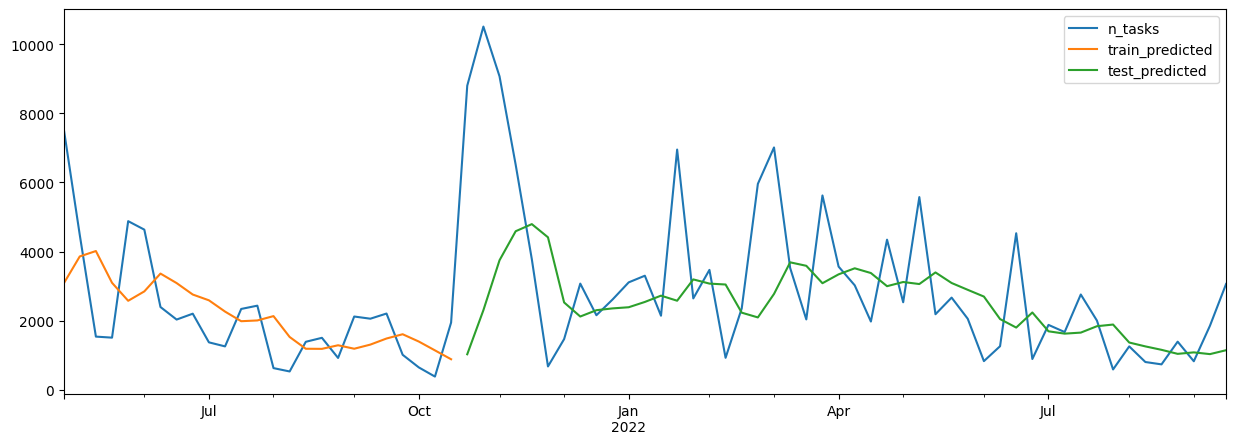

In [22]:
log_ntasks_ts = np.log(ds_group_ts + 1)
log_ntasks_diff = log_ntasks_ts.diff().dropna()
n_lags = 32
Xtrain, Ytrain, Xtest, Ytest = create_dataset(log_ntasks_diff, n_lags)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(24, input_shape=(n_lags, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

train_idx = ds_group_ts.index[1 + n_lags: 1 + n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[1 + n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()

prev = log_ntasks_ts.shift().dropna()
Ytrain_predicted = Ytrain_predicted + prev[train_idx].to_numpy()
Ytest_predicted = Ytest_predicted + prev[test_idx].to_numpy()

results = pd.DataFrame({'n_tasks' : ds_group_ts})
results.loc[train_idx, 'train_predicted'] = np.exp(Ytrain_predicted) - 1
results.loc[test_idx, 'test_predicted'] = np.exp(Ytest_predicted) - 1

results[200:].plot(figsize=(15, 5))
print('MSE =', ((results['test_predicted'][test_idx] - results['n_tasks'][test_idx])**2).mean())
MAPE = mean_absolute_percentage_error(results['n_tasks'][test_idx],
                                      results['test_predicted'][test_idx])
print('MAPE =', MAPE)

## Way 4

Predicting log (N_USERS + 1) / 12.0
with a LSTM(24) Cell + Dense layer

Epoch 1/100
6/6 [==============================] - 2s 63ms/step - loss: 0.3689 - val_loss: 0.2357
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1786 - val_loss: 0.0925
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0573 - val_loss: 0.0155
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.0170
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 11/100
6/6 [==========

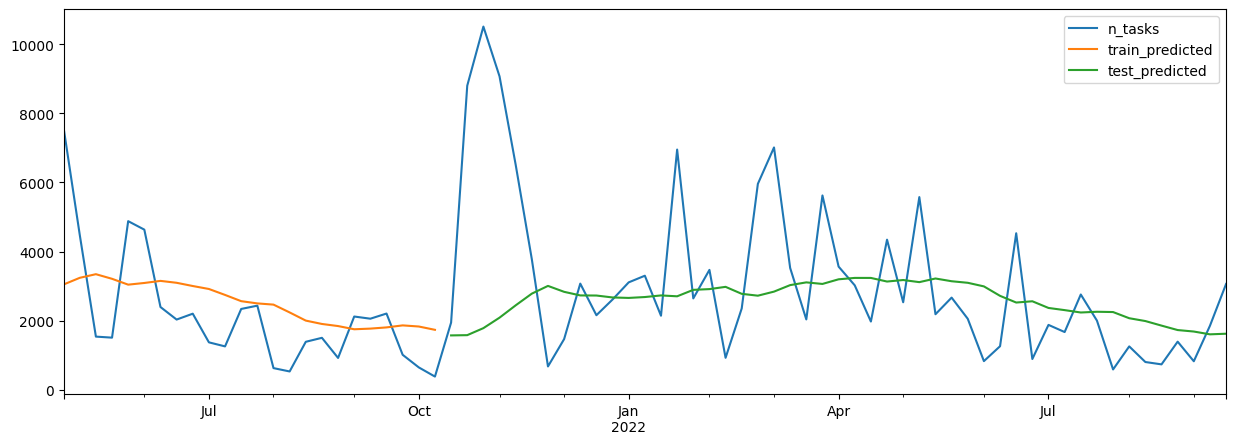

In [23]:
maxlog_ntasks = 12.0
log_ntasks_ts = np.log(ds_group_ts + 1) / maxlog_ntasks
n_lags = 32
Xtrain, Ytrain, Xtest, Ytest = create_dataset(log_ntasks_ts, n_lags)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(24, input_shape=(n_lags, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

train_idx = ds_group_ts.index[n_lags: n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()


results = pd.DataFrame({'n_tasks' : ds_group_ts})
results.loc[train_idx, 'train_predicted'] = np.exp(Ytrain_predicted * maxlog_ntasks) - 1
results.loc[test_idx, 'test_predicted'] = np.exp(Ytest_predicted * maxlog_ntasks) - 1

results[200:].plot(figsize=(15, 5))
print('MSE =', ((results['test_predicted'][test_idx] - results['n_tasks'][test_idx])**2).mean())
MAPE = mean_absolute_percentage_error(results['n_tasks'][test_idx],
                                      results['test_predicted'][test_idx])
print('MAPE =', MAPE)

## Way 5
Predicting Diff (log (N_USERS + 1))
with a GRU(24) Cell + Dense layer

Epoch 1/100
6/6 [==============================] - 2s 69ms/step - loss: 0.5401 - val_loss: 0.6550
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5251 - val_loss: 0.6420
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5118 - val_loss: 0.6301
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4984 - val_loss: 0.6192
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4870 - val_loss: 0.6088
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4736 - val_loss: 0.5996
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4626 - val_loss: 0.5911
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4522 - val_loss: 0.5838
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4419 - val_loss: 0.5762
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4324 - val_loss: 0.5701
Epoch 11/100
6/6 [==========

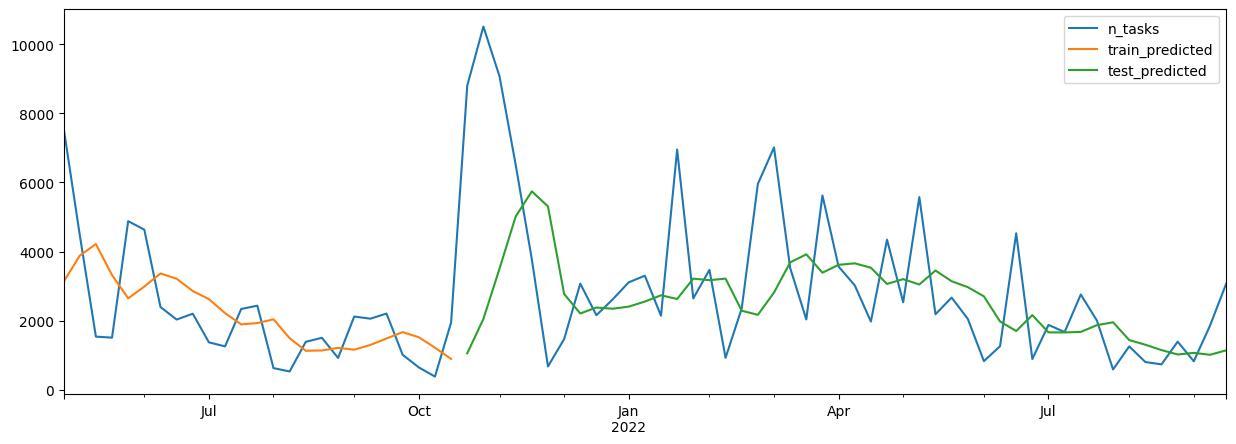

In [24]:
log_ntasks_ts = np.log(ds_group_ts + 1)
log_ntasks_diff = log_ntasks_ts.diff().dropna()
n_lags = 32
Xtrain, Ytrain, Xtest, Ytest = create_dataset(log_ntasks_diff, n_lags)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(24, input_shape=(n_lags, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

train_idx = ds_group_ts.index[1 + n_lags: 1 + n_lags + len(Ytrain)]
test_idx = ds_group_ts.index[1 + n_lags + len(Ytrain):]

Ytrain_predicted = model.predict(Xtrain).flatten()
Ytest_predicted = model.predict(Xtest).flatten()

prev = log_ntasks_ts.shift().dropna()
Ytrain_predicted = Ytrain_predicted + prev[train_idx].to_numpy()
Ytest_predicted = Ytest_predicted + prev[test_idx].to_numpy()

results = pd.DataFrame({'n_tasks' : ds_group_ts})
results.loc[train_idx, 'train_predicted'] = np.exp(Ytrain_predicted) - 1
results.loc[test_idx, 'test_predicted'] = np.exp(Ytest_predicted) - 1

results[200:].plot(figsize=(15, 5))
print('MSE =', ((results['test_predicted'][test_idx] - results['n_tasks'][test_idx])**2).mean())
MAPE = mean_absolute_percentage_error(results['n_tasks'][test_idx],
                                      results['test_predicted'][test_idx])
print('MAPE =', MAPE)

## Way 6
Facebook Prophet

15:54:29 - cmdstanpy - INFO - Chain [1] start processing
15:54:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.6224798849202455


<AxesSubplot: xlabel='ds'>

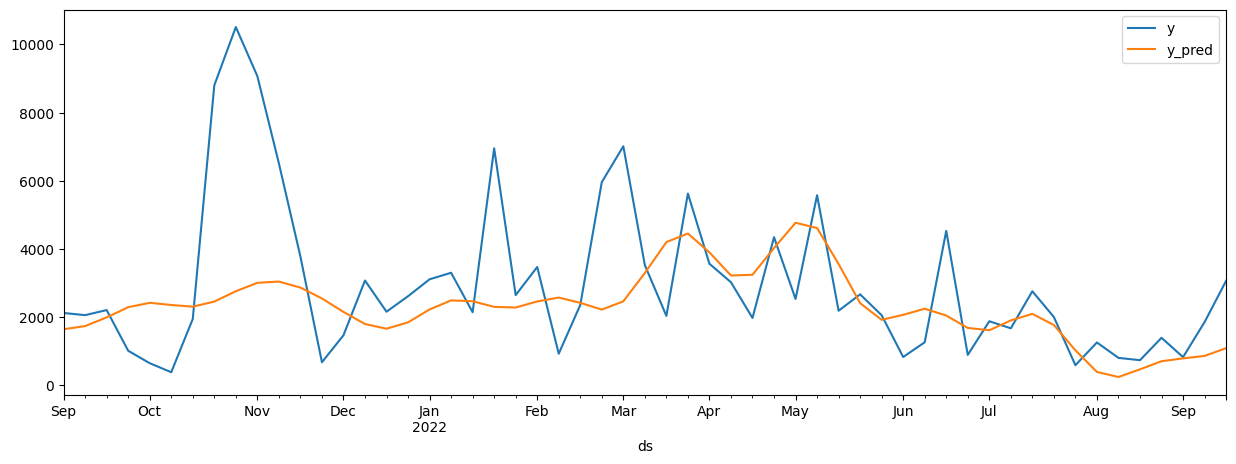

In [25]:
ts_prophet = pd.DataFrame(ds_group_ts)
ts_prophet.reset_index(inplace=True)
ts_prophet.columns = ['ds', 'y']

train_len = int(len(ts_prophet) * 0.8)
test_len = len(ts_prophet) - train_len


ts_prophet_train = ts_prophet[:train_len]


m = Prophet()
m.fit(ts_prophet_train)

future = m.make_future_dataframe(periods=test_len, freq='W')
forecast = m.predict(future)

results = pd.DataFrame({'y' : ts_prophet['y'][train_len:].tolist(),
                        'y_pred' : forecast['yhat'][train_len:].tolist()},
                       index=ts_prophet['ds'][train_len:])
MAPE = mean_absolute_percentage_error(results['y'],
                                      results['y_pred'])
print('MAPE =', MAPE)
results.plot(figsize=(15,5))

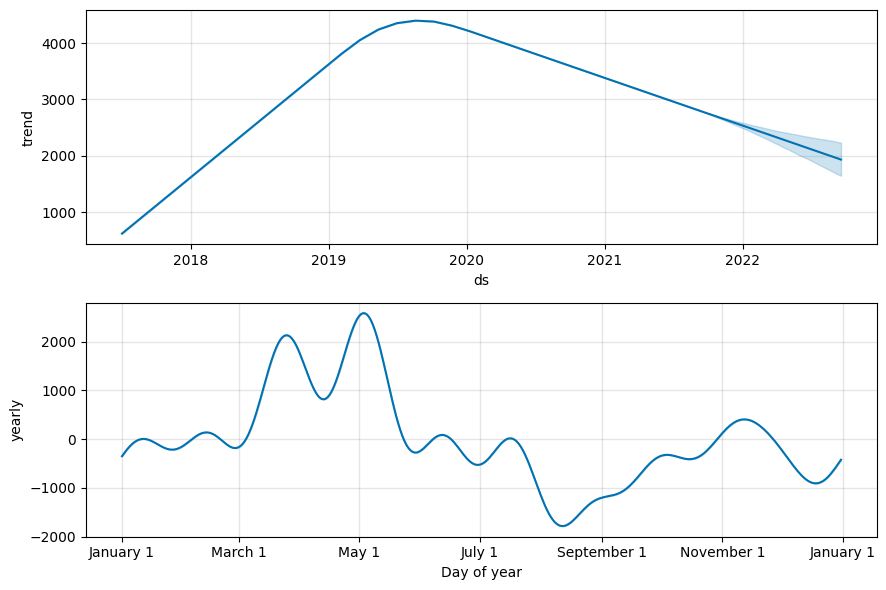

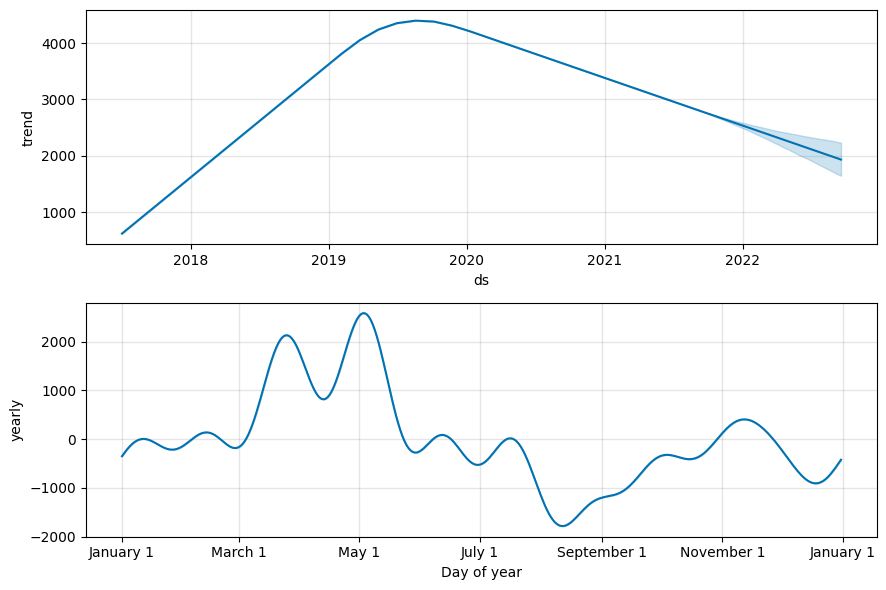

In [26]:
m.plot_components(forecast)

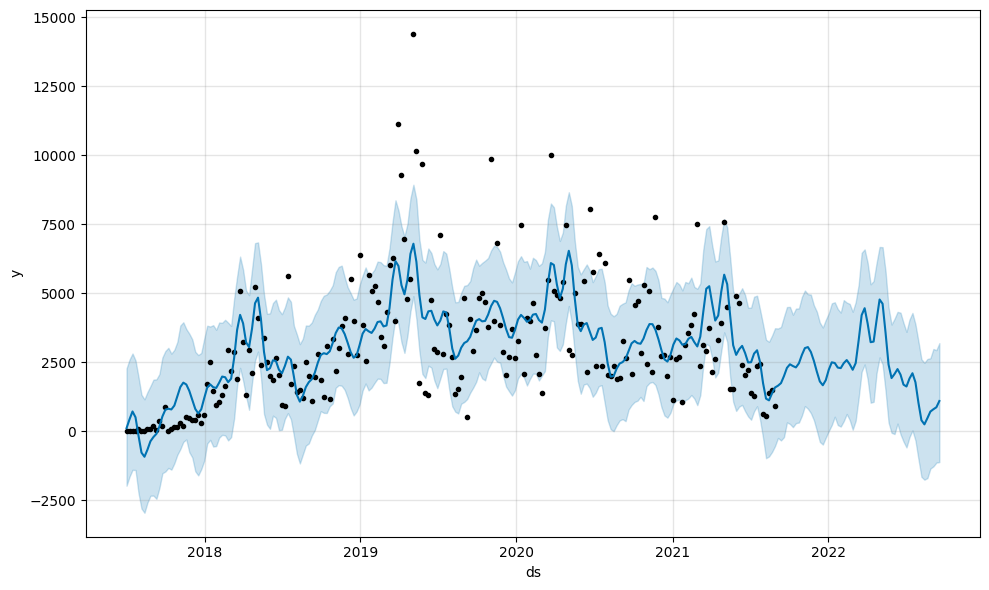

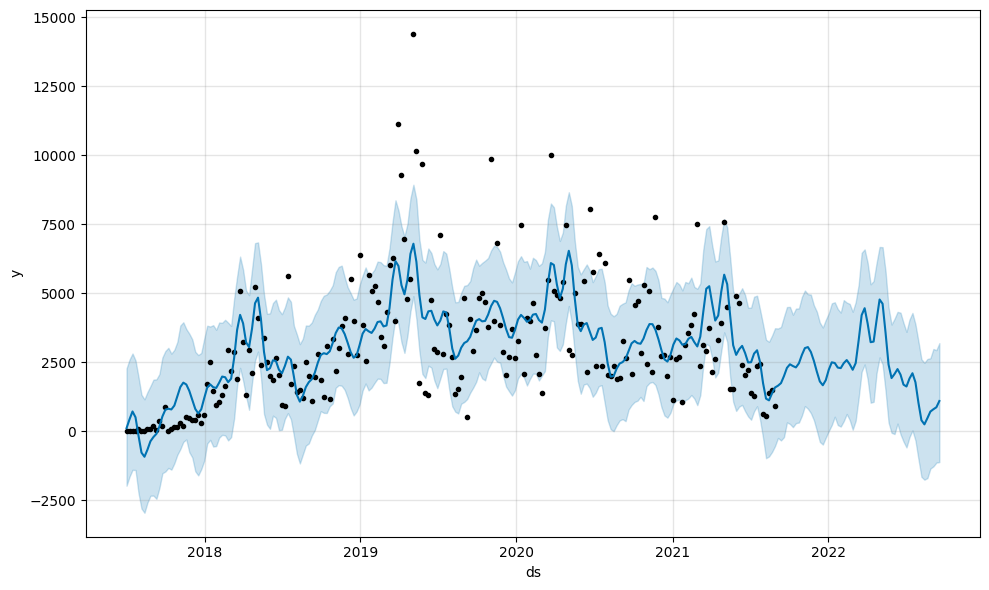

In [27]:
m.plot(forecast)

15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.0650232629419624


<AxesSubplot: xlabel='ds'>

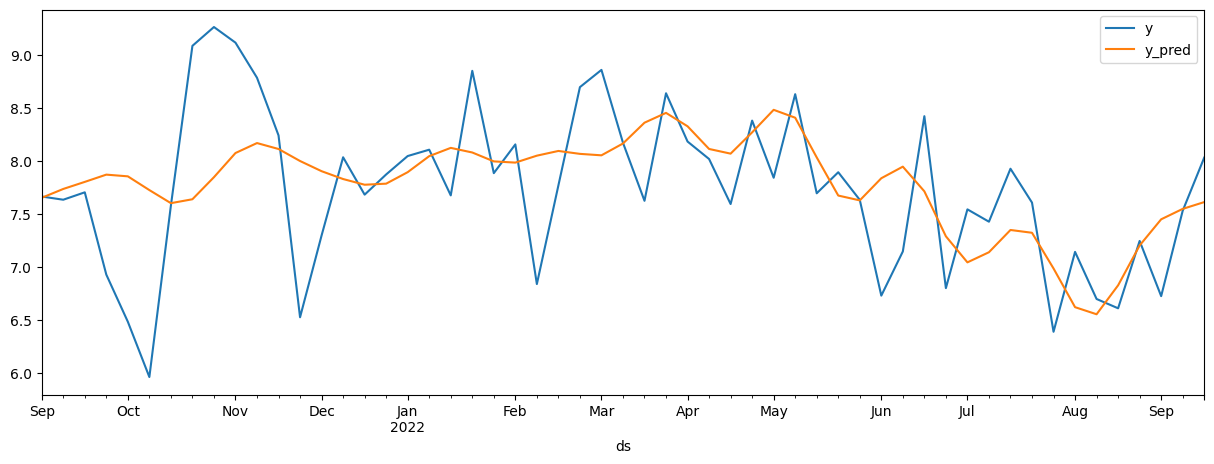

In [28]:
ts_prophet = pd.DataFrame(ds_group_ts)
ts_prophet.reset_index(inplace=True)
ts_prophet.columns = ['ds', 'y']

ts_prophet['y'] = np.log(ts_prophet['y'] + 1)

train_len = int(len(ts_prophet) * 0.8)
test_len = len(ts_prophet) - train_len

ts_prophet_train = ts_prophet[:train_len]


m = Prophet()
m.fit(ts_prophet_train)

future = m.make_future_dataframe(periods=test_len, freq='W')
forecast = m.predict(future)

results = pd.DataFrame({'y' : ts_prophet['y'][train_len:].tolist(),
                        'y_pred' : forecast['yhat'][train_len:].tolist()},
                       index=ts_prophet['ds'][train_len:])
MAPE = mean_absolute_percentage_error(results['y'],
                                      results['y_pred'])
print('MAPE =', MAPE)
results.plot(figsize=(15,5))

MAPE = 0.6364943383352277


<AxesSubplot: xlabel='ds'>

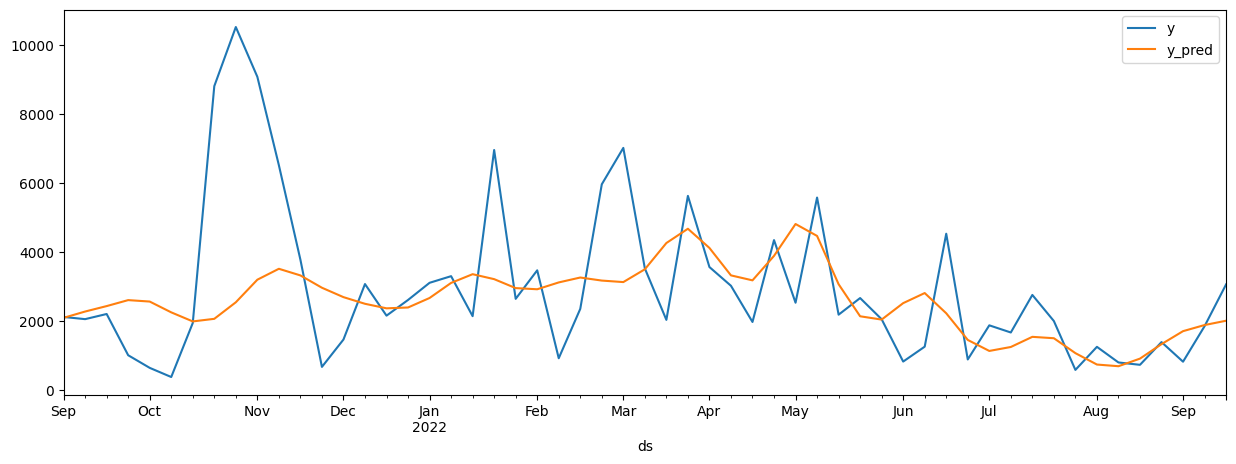

In [29]:
results['y'] = np.exp(results['y']) - 1
results['y_pred'] = np.exp(results['y_pred']) - 1
MAPE = mean_absolute_percentage_error(results['y'],
                                      results['y_pred'])
print('MAPE =', MAPE)
results.plot(figsize=(15,5))